In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import Checkbox, Button, RadioButtons, DatePicker, Label, HBox, VBox, Output
from IPython.display import clear_output
from math import ceil

In [33]:
def pull_data(mode='confimed'):
    url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{mode}_global.csv'
    df = pd.read_csv(url,error_bad_lines=False)
    #print(f'{mode} data pulled')
    return df

In [34]:
def run_analysis(df, mode, since, **kwargs):

    if all(v is False for v in kwargs.values()):
        print('Select at least one country from the list below:')
        return
    
    # Annotate countries as 'country', Provinces/States as 'regions', and add 'world'
    countries_dict = {k : 'country' for k,v in kwargs.items() if v}    
    valid_countries =  df['Country/Region'].unique()
    for k in countries_dict.keys():
        if k == 'World':  
            countries_dict[k] = 'world'
        elif k not in valid_countries:
            countries_dict[k] = 'region'
    
    # Create dict for second plot (only constructed after loop)
    doubling_results = {}
    
    # Construct figure for plots
    fig = plt.figure(figsize=(15, 20))
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)
    
    for country, area_type in countries_dict.items():
            
        if area_type == 'region':
            q = pd.DataFrame(df[df['Province/State'] == country].sum()[4:])
        elif area_type == 'country':
            q = pd.DataFrame(df[df['Country/Region'] == country].sum()[4:])
        elif area_type == 'world':
            q = pd.DataFrame(df.sum()[4:])
        q.reset_index(inplace=True)
        q.columns = ['date', 'cases']
        q['date'] = q.date.apply(pd.to_datetime)
        q.set_index(q.date, inplace=True)
        q = q.loc[since:]

        # Plot 1: log cases per day
        q['cases'].plot(ax=ax1)
        ax1.legend(countries_dict.keys());
        ax1.set_yscale('log', basey=2)
        ax1.set_title(f'Total {mode} by country/region')

        # Get doubling time per country for plot 2
        r = q.copy()
        r['cases'] = r.cases.apply(lambda x: np.log2(x))
        x = r['cases'].min()
        if x == float("inf") or x == float("-inf"):
            x=0
        rate = (r['cases'].max() - x) / (r['date'].max() - r['date'].min()).days
        period = 1/rate
        doubling_results[country] = period

        # Plot 3: New cases 3-day rolling average
        n = 5
        q['dc/dt'] = q['cases'].diff()
        q['rolling'] = q['dc/dt'].rolling(n).mean()

        max_change = q['rolling'].max()
        q['rolling'] = q['rolling'].apply(lambda x: x/ max_change)
        q = q[~q['rolling'].isna()]
        q['rolling'].plot(ax = ax3);
        ax3.legend(countries_dict.keys());
        ax3.set_title(f'New daily {mode} by country/region, {n}-day rolling average as function of maximum')


    # Plot 2 : doubling time
    pd.DataFrame(pd.Series(doubling_results).sort_values(ascending=False)).plot(kind='bar', ax=ax2)
    ax2.set_title(f'{mode} doubling time by country/region since {since}')
    
    plt.tight_layout()
    return

In [39]:
def main():

    #Pull data
    df_cases = pull_data(mode='confirmed')
    df_deaths = pull_data(mode='deaths')

    # Create Radio button widgets to set df_cases or df_deaths
    mode = RadioButtons(options=['Confirmed cases', 'Deaths'], value='Confirmed cases', disabled=False)

    # Create list of checkbox widgets for countries, canadian provinces, and World
    countries = list(df_cases['Country/Region'].unique())
    provinces = list(df_cases[df_cases['Country/Region'] == 'Canada']['Province/State'].unique())
    l = countries + provinces + ['World']
    chk = [Checkbox(description=a) for a in l]

    # Create datepicker widget for 'since' argument
    date = DatePicker()

    # Create button and output widgets
    run_button = Button(description="Run Analysis")

    # Create button to select all checkboxes
    select_button = Button(description="Select all")

    # Create button to deselect all checkboxes
    deselect_button = Button(description="Deselect all")

    # Create widget to hold output
    output = Output()


    # Functions to execute on button clicks
    def run_and_output(run_button):
        # Handle case where use forgets to select a date
        try:
            since = date.value.strftime("%-m/%-d/%Y")
        except AttributeError:
            print('Please select a date')
            return
        if mode.value == 'Confirmed cases':
            df = df_cases
        else:
            df = df_deaths

        clear_output()
        with output:
            run_analysis(df=df, mode=mode.value, since=since, **{c.description: c.value for c in chk})
        display(all_widgets)


    def select_all(select_button):
        clear_output()
        for c in chk:
            c.value = True
        display(all_widgets)


    def deselect_all(deselect_button):
        clear_output()
        for c in chk:
            c.value = False
        display(all_widgets)


    # Assign function to buttons    
    run_button.on_click(run_and_output)
    select_button.on_click(select_all)
    deselect_button.on_click(deselect_all)

    # Organize checkboxes layout
    width = 4
    height = ceil(len(l)/width)
    v_boxes = [VBox(chk[(i*height): (i+1)*height]) for i in range(width)]
    checkboxes = HBox(v_boxes)

    # Organise widgets
    mode_bar = HBox([Label('Select mode:'), mode])
    control = HBox([VBox([select_button, deselect_button]), run_button])
    top_bar= HBox([Label('Analyse cases since:'), date, control])
    all_widgets = VBox([mode_bar, top_bar, checkboxes, output])

    # Cast widgets to screen
    display(all_widgets)

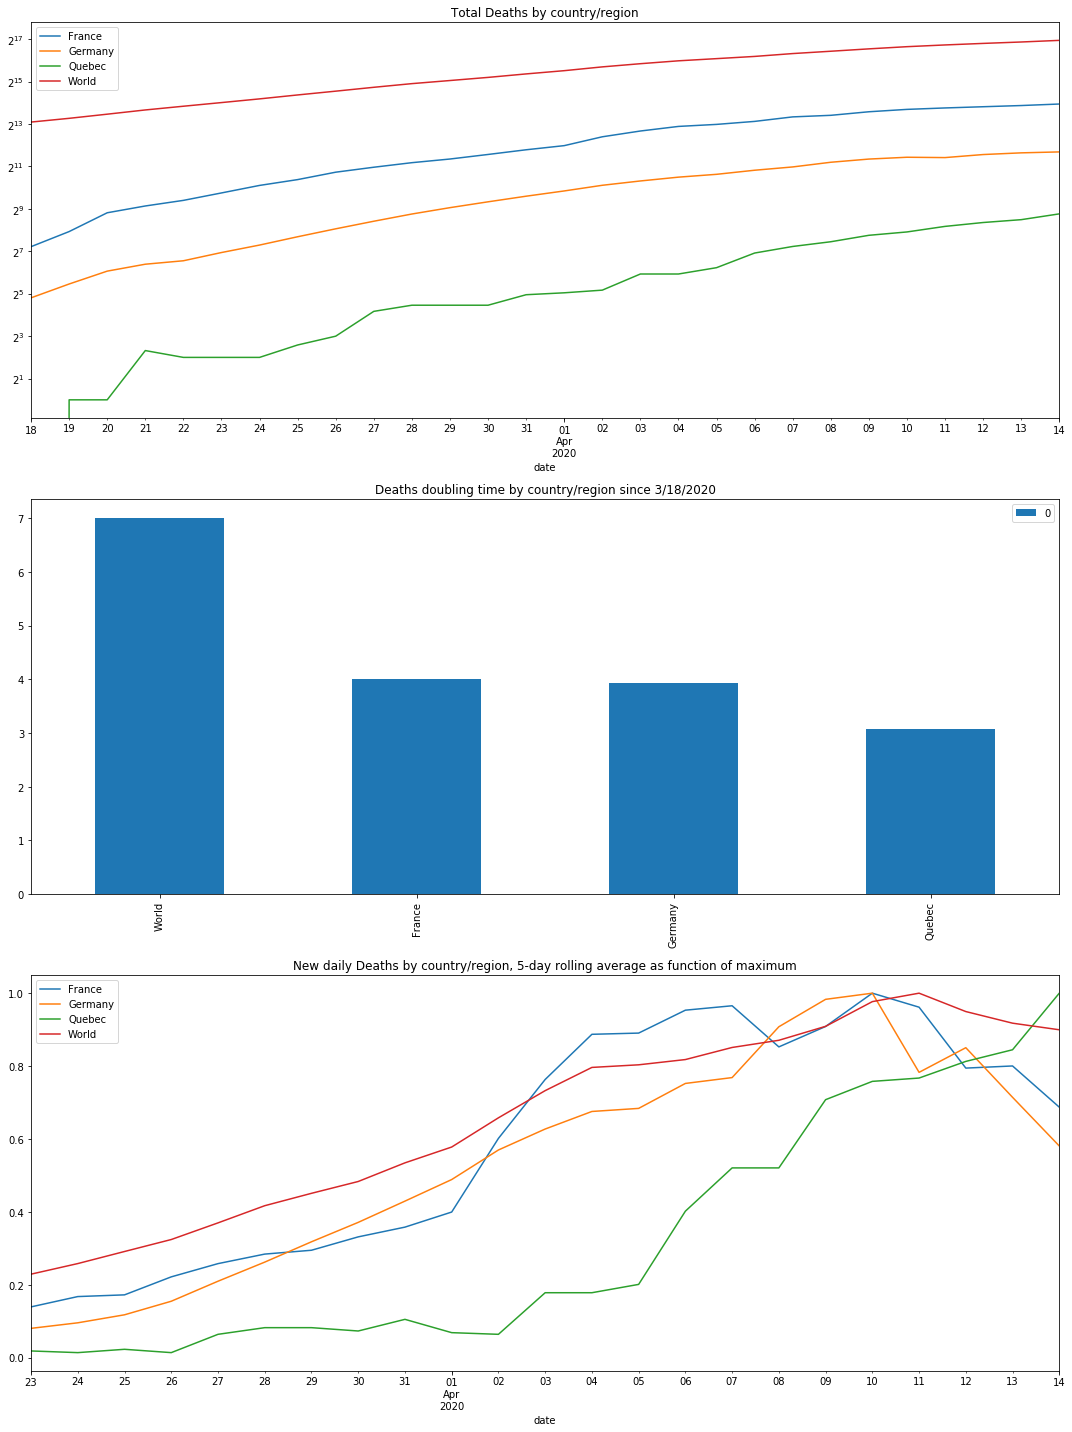

In [40]:
main()